# Question Generation

This is a bare bones tutorial showing what is possible with the QuestionGenerator Nodes and Pipelines which automatically
generate questions which the question generation model thinks can be answered by a given document.


## Preparing the Colab Environment

- [Enable GPU Runtime](https://docs.haystack.deepset.ai/docs/enabling-gpu-acceleration#enabling-the-gpu-in-colab)


## Installing Haystack

To start, let's install the latest release of Haystack with `pip`:

In [2]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,elasticsearch,inference]

  Using cached elastic_transport-7.16.0-py2.py3-none-any.whl.metadata (8.1 kB)
  Using cached elasticsearch-7.17.12-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached protobuf-5.28.3-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached MarkupSafe-3.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 240.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 168.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 233.0 kB/s eta 0:00:0000:0100:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 273.6 kB/s eta 0:00:00a 0:00:01
Using cached protobuf-5.28.3-cp38-abi3-macosx_10_9_universal2.whl (414 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached MarkupSafe-3.0.2-cp39-cp39-macosx_11_0_arm64.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 767.2

### Enabling Telemetry 
Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry) for more details.

In [3]:
from haystack.telemetry import tutorial_running

tutorial_running(13)

/opt/anaconda3/envs/haystack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Logging

We configure how logging messages should be displayed and which log level should be used before importing Haystack.
Example log message:
INFO - haystack.utils.preprocessing -  Converting data/tutorial1/218_Olenna_Tyrell.txt
Default log level in basicConfig is WARNING so the explicit parameter is not necessary but can be changed easily:

In [1]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [2]:
# Imports needed to run this notebook

from pprint import pprint
from tqdm.auto import tqdm
from haystack.nodes import QuestionGenerator, BM25Retriever, FARMReader
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.pipelines import (
    QuestionGenerationPipeline,
    RetrieverQuestionGenerationPipeline,
    QuestionAnswerGenerationPipeline,
)
from haystack.utils import launch_es, print_questions

/opt/anaconda3/envs/haystack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's start an Elasticsearch instance with one of the options below:

In [7]:
# Option 1: Start Elasticsearch service via Docker
launch_es()

Unable to find image 'elasticsearch:7.17.6' locally
7.17.6: Pulling from library/elasticsearch
57ed440d6d89: Pulling fs layer
a749a280e3e9: Pulling fs layer
72050ffc35ca: Pulling fs layer
47e52584ee03: Pulling fs layer
73b52868e110: Pulling fs layer
d51844c6f6ab: Pulling fs layer
eacd8a3b0316: Pulling fs layer
a666a9c77b42: Pulling fs layer
3dfebdff3d8d: Pulling fs layer
3dfebdff3d8d: Download complete
47e52584ee03: Download complete
eacd8a3b0316: Download complete
d51844c6f6ab: Download complete
57ed440d6d89: Download complete
a666a9c77b42: Download complete
a749a280e3e9: Download complete
72050ffc35ca: Download complete
73b52868e110: Download complete
Digest: sha256:6c128de5d01c0c130a806022d6bd99b3e4c27a9af5bfc33b6b81861ae117d028
Status: Downloaded newer image for elasticsearch:7.17.6


6d49a2c3819ccb05cef09060ef28ff6e39854c7a2764d1c9c1fe299b0b1544a1


Let's initialize some core components

In [3]:
text1 = "Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Rossum and first released in 1991, Python's design philosophy emphasizes code readability with its notable use of significant whitespace."
text2 = "Princess Arya Stark is the third child and second daughter of Lord Eddard Stark and his wife, Lady Catelyn Stark. She is the sister of the incumbent Westerosi monarchs, Sansa, Queen in the North, and Brandon, King of the Andals and the First Men. After narrowly escaping the persecution of House Stark by House Lannister, Arya is trained as a Faceless Man at the House of Black and White in Braavos, using her abilities to avenge her family. Upon her return to Westeros, she exacts retribution for the Red Wedding by exterminating the Frey male line."
text3 = "Dry Cleaning are an English post-punk band who formed in South London in 2018.[3] The band is composed of vocalist Florence Shaw, guitarist Tom Dowse, bassist Lewis Maynard and drummer Nick Buxton. They are noted for their use of spoken word primarily in lieu of sung vocals, as well as their unconventional lyrics. Their musical stylings have been compared to Wire, Magazine and Joy Division.[4] The band released their debut single, 'Magic of Meghan' in 2019. Shaw wrote the song after going through a break-up and moving out of her former partner's apartment the same day that Meghan Markle and Prince Harry announced they were engaged.[5] This was followed by the release of two EPs that year: Sweet Princess in August and Boundary Road Snacks and Drinks in October. The band were included as part of the NME 100 of 2020,[6] as well as DIY magazine's Class of 2020.[7] The band signed to 4AD in late 2020 and shared a new single, 'Scratchcard Lanyard'.[8] In February 2021, the band shared details of their debut studio album, New Long Leg. They also shared the single 'Strong Feelings'.[9] The album, which was produced by John Parish, was released on 2 April 2021.[10]"

docs = [{"content": text1}, {"content": text2}, {"content": text3}]

# Initialize document store and write in the documents
document_store = ElasticsearchDocumentStore()
document_store.write_documents(docs)

# Initialize Question Generator
question_generator = QuestionGenerator()

/opt/anaconda3/envs/haystack/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
INFO - haystack.modeling.utils -  Using devices: MPS - Number of GPUs: 1
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[nltk_data] Downloading package punkt_tab to
[nltk_da

## Question Generation Pipeline

The most basic version of a question generator pipeline takes a document as input and outputs generated questions
which the the document can answer.

In [4]:
question_generation_pipeline = QuestionGenerationPipeline(question_generator)
for idx, document in enumerate(document_store):

    print(f"\n * Generating questions for document {idx}: {document.content[:100]}...\n")
    result = question_generation_pipeline.run(documents=[document])
    print_questions(result)


 * Generating questions for document 0: Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Ros...


Generated questions:
 - Who created Python?
 - When was Python first released?
 - What is Python's design philosophy?

 * Generating questions for document 1: Princess Arya Stark is the third child and second daughter of Lord Eddard Stark and his wife, Lady C...


Generated questions:
 - Who is the third child and second daughter of Lord Eddard Stark and his wife, Lady Catelyn Stark?
 - Princess Arya Stark is the sister of what Westerosi monarchs?
 - What is Sansa, Queen in the North, and Brandon, King of the Andals?
 - What is Arya trained as?
 - Where is the House of Black and White located?
 - What is the name of the first men?
 - What is the name of the line that Frey exterminates?
 - Where does the Red Wedding take place?

 * Generating questions for document 2: Dry Cleaning are an English post-punk band who formed in South London in 20

## Retriever Question Generation Pipeline

This pipeline takes a query as input. It retrieves relevant documents and then generates questions based on these.

In [6]:
retriever = BM25Retriever(document_store=document_store)
rqg_pipeline = RetrieverQuestionGenerationPipeline(retriever, question_generator)

print(f"\n * Generating questions for documents matching the query 'Arya Stark'\n")
result = rqg_pipeline.run(query="Arya Stark")
print_questions(result)


 * Generating questions for documents matching the query 'Arya Stark'


Generated questions:
 - Who is the third child and second daughter of Lord Eddard Stark and his wife, Lady Catelyn Stark?
 - Princess Arya Stark is the sister of what Westerosi monarchs?
 - What is Sansa, Queen in the North, and Brandon, King of the Andals?
 - What is Arya trained as?
 - Where is the House of Black and White located?
 - What is the name of the first men?
 - What is the name of the line that Frey exterminates?
 - Where does the Red Wedding take place?


## Question Answer Generation Pipeline

This pipeline takes a document as input, generates questions on it, and attempts to answer these questions using
a Reader model

In [7]:
reader = FARMReader("deepset/roberta-base-squad2")
qag_pipeline = QuestionAnswerGenerationPipeline(question_generator, reader)
for idx, document in enumerate(tqdm(document_store)):

    print(f"\n * Generating questions and answers for document {idx}: {document.content[:100]}...\n")
    result = qag_pipeline.run(documents=[document])
    print_questions(result)

INFO - haystack.modeling.utils -  Using devices: MPS - Number of GPUs: 1
INFO - haystack.modeling.utils -  Using devices: MPS - Number of GPUs: 1
INFO - haystack.modeling.model.language_model -   * LOADING MODEL: 'deepset/roberta-base-squad2' (Roberta)
INFO - haystack.modeling.model.language_model -  Auto-detected model language: english
INFO - haystack.modeling.model.language_model -  Loaded 'deepset/roberta-base-squad2' (Roberta model) from model hub.
INFO - haystack.modeling.utils -  Using devices: MPS - Number of GPUs: 1
0it [00:00, ?it/s]


 * Generating questions and answers for document 0: Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Ros...



Inferencing Samples:   0%|          | 0/1 [00:02<?, ? Batches/s]
0it [00:03, ?it/s]


Exception: Exception while running node 'Reader': The operator 'aten::tril_indices' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.
Enable debug logging to see the data that was passed when the pipeline failed.

## Translated Question Answer Generation Pipeline
Trained models for Question Answer Generation are not available in many languages other than English. Haystack
provides a workaround for that issue by machine-translating a pipeline's inputs and outputs with the
TranslationWrapperPipeline. The following example generates German questions and answers on a German text
document - by using an English model for Question Answer Generation.

In [ ]:
# Fill the document store with a German document.
text1 = "Python ist eine interpretierte Hochsprachenprogrammiersprache für allgemeine Zwecke. Sie wurde von Guido van Rossum entwickelt und 1991 erstmals veröffentlicht. Die Design-Philosophie von Python legt den Schwerpunkt auf die Lesbarkeit des Codes und die Verwendung von viel Leerraum (Whitespace)."
docs = [{"content": text1}]
document_store.delete_documents()
document_store.write_documents(docs)

# Load machine translation models
from haystack.nodes import TransformersTranslator

in_translator = TransformersTranslator(model_name_or_path="Helsinki-NLP/opus-mt-de-en")
out_translator = TransformersTranslator(model_name_or_path="Helsinki-NLP/opus-mt-en-de")

# Wrap the previously defined QuestionAnswerGenerationPipeline
from haystack.pipelines import TranslationWrapperPipeline

pipeline_with_translation = TranslationWrapperPipeline(
    input_translator=in_translator, output_translator=out_translator, pipeline=qag_pipeline
)

for idx, document in enumerate(tqdm(document_store)):
    print(f"\n * Generating questions and answers for document {idx}: {document.content[:100]}...\n")
    result = pipeline_with_translation.run(documents=[document])
    print_questions(result)

In [7]:
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

from haystack.document_stores.types import DuplicatePolicy
from haystack import Document, Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.utils import Secret
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
import os
from dotenv import load_dotenv
from haystack.components.embedders import AzureOpenAITextEmbedder,AzureOpenAIDocumentEmbedder
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
load_dotenv()
document_store = ElasticsearchDocumentStore(hosts= "http://localhost:9200/")

model = "BAAI/bge-large-en-v1.5"

documents = [Document(content="There are over 7,000 languages spoken around the world today."),
						Document(content="Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors."),
						Document(content="In certain parts of the world, like the Maldives, Puerto Rico, and San Diego, you can witness the phenomenon of bioluminescent waves.")]

text_embedder = AzureOpenAITextEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("EMBEDDING_MODEL"))
document_embedder = AzureOpenAIDocumentEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("EMBEDDING_MODEL"))
documents_with_embeddings = document_embedder.run(documents)

document_store.write_documents(documents_with_embeddings.get("documents"), policy=DuplicatePolicy.SKIP)

query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", text_embedder)
query_pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store))
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

query = "How many languages are there?"

result = query_pipeline.run({"text_embedder": {"text": query}})

print(result['retriever']['documents'][0])

Embedding Texts:   0%|          | 0/1 [00:00<?, ?it/s]

method='post' url='/embeddings' params={} headers=NOT_GIVEN max_retries=NOT_GIVEN timeout=NOT_GIVEN files=None idempotency_key=None post_parser=<function Embeddings.create.<locals>.parser at 0x124f2d550> json_data={'input': ['There are over 7,000 languages spoken around the world today.', 'Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors.', 'In certain parts of the world, like the Maldives, Puerto Rico, and San Diego, you can witness the phenomenon of bioluminescent waves.'], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'} extra_json=None
method='post' url='/embeddings' params={} headers=NOT_GIVEN max_retries=NOT_GIVEN timeout=NOT_GIVEN files=None idempotency_key=None post_parser=<function Embeddings.create.<locals>.parser at 0x124f2d550> json_data={'input': ['There are over 7,000 languages spoken around the world today.', 'Elephants have been observed to behave in a way that indicat

Embedding Texts: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


DocumentStoreError: Failed to write documents to Elasticsearch. Errors:
[{'create': {'_index': 'default', '_type': '_doc', '_id': 'cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'illegal_argument_exception', 'reason': 'Field [embedding] of type [dense_vector] of doc [cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94] has exceeded the number of dimensions [768] defined in mapping'}}}}, {'create': {'_index': 'default', '_type': '_doc', '_id': '6f20658aeac3c102495b198401c1c0c2bd71d77b915820304d4fbc324b2f3cdb', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'illegal_argument_exception', 'reason': 'Field [embedding] of type [dense_vector] of doc [6f20658aeac3c102495b198401c1c0c2bd71d77b915820304d4fbc324b2f3cdb] has exceeded the number of dimensions [768] defined in mapping'}}}}, {'create': {'_index': 'default', '_type': '_doc', '_id': '7f225626ad1019b273326fbaf11308edfca6d663308a4a3533ec7787367d59a2', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'illegal_argument_exception', 'reason': 'Field [embedding] of type [dense_vector] of doc [7f225626ad1019b273326fbaf11308edfca6d663308a4a3533ec7787367d59a2] has exceeded the number of dimensions [768] defined in mapping'}}}}]

In [8]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
import os
from dotenv import load_dotenv
from haystack.components.embedders import AzureOpenAITextEmbedder
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

from haystack import Pipeline
from dotenv import load_dotenv
load_dotenv()

class CreateQuestionPipeline():
    def __init__(self):
        pass
        
    def find_similar_documents(self,question:str):
        pipeline=Pipeline()
        document_store = ElasticsearchDocumentStore(hosts= "http://localhost:9200/",index="storage")
        embeder=AzureOpenAITextEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("EMBEDDING_MODEL"))
        pipeline.add_component("embedder",embeder)
        pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store))
        pipeline.connect("embedder.embedding", "retriever.query_embedding")
        results = pipeline.run({"embedder": {"text": question}})
        return results
check_var=CreateQuestionPipeline()
# result=check_var.find_similar_documents("What is cloud computing?")

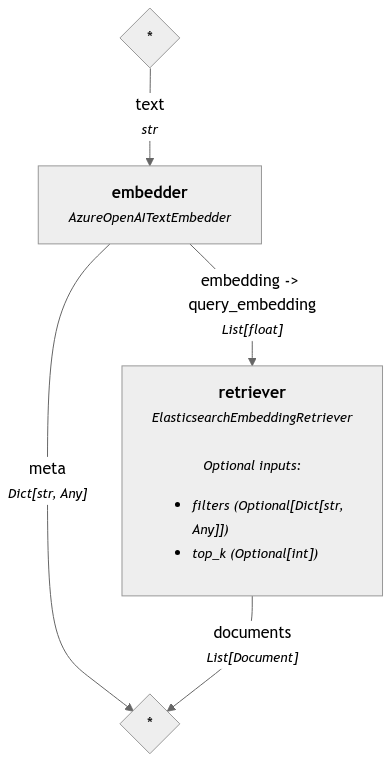

In [14]:
pipeline=Pipeline()
document_store = ElasticsearchDocumentStore(hosts= "http://localhost:9200/",index="storage")
embeder=AzureOpenAITextEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                azure_deployment=os.getenv("EMBEDDING_MODEL"))
pipeline.add_component("embedder",embeder)
pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store))
pipeline.connect("embedder.embedding", "retriever.query_embedding")
pipeline.show()

In [ ]:
from haystack.document_stores.types import DuplicatePolicy
from haystack import Document
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder

from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore

document_store = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
)

documents = [Document(content="There are over 7,000 languages spoken around the world today."),
						Document(content="Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors."),
						Document(content="In certain parts of the world, like the Maldives, Puerto Rico, and San Diego, you can witness the phenomenon of bioluminescent waves.")]
embeder=AzureOpenAITextEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                azure_deployment=os.getenv("EMBEDDING_MODEL"))
documents_with_embeddings = document_embedder.run(documents)

document_store.write_documents(documents_with_embeddings.get("documents"), policy=DuplicatePolicy.OVERWRITE)

query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder())
query_pipeline.add_component("retriever", QdrantEmbeddingRetriever(document_store=document_store))
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

query = "How many languages are there?"

result = query_pipeline.run({"text_embedder": {"text": query}})

print(result['retriever']['documents'][0])

/opt/anaconda3/envs/2024_dx_bootcamp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: Failed to import 'sentence_transformers'. Run 'pip install "sentence-transformers>=3.0.0"'. Original error: No module named 'sentence_transformers'